<a href="https://colab.research.google.com/github/ybw9000/torch_Dtensor_playground/blob/main/Torch_DDP_refresh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.functional as F

In [2]:
class LogReg(nn.Module):
    def __init__(self, input_dim, output_dim):
      super().__init__()
      self.linear = nn.Linear(input_dim, output_dim)
      self.ce = nn.CrossEntropyLoss()

    def forward(self, x, label):
      out = self.linear(x)
      loss = self.ce(out, label)
      return out, loss

In [3]:
# prompt: create a minst dataset in torch
from torchvision import datasets, transforms

# Create MNIST dataset and dataloader
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

train_data = datasets.MNIST('../data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False, transform=transform)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=True)


# Example usage (optional):
# input_dim = 784  # 28x28 image
# output_dim = 10  # 10 classes (0-9)
# model = LogReg(input_dim, output_dim)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 158MB/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 14.8MB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 95.8MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.73MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
model = LogReg(784, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

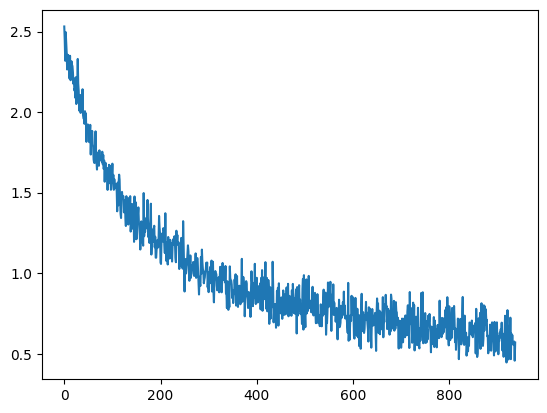

In [6]:
import matplotlib.pyplot as plt

losses = []
for data, target in train_loader:
    logits, loss = model(data.reshape(data.shape[0], -1), target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.show()

In [20]:
import torch.multiprocessing as mp
import torch.distributed as dist

def setup_device(rank, world_size):
    # Device setup
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "56492"
    torch.distributed.init_process_group(
        backend="gloo",
        init_method="env://",
        world_size=world_size,
        rank=rank,
    )

# Define the training function for each process
def train(rank, world_size, model, train_loader, optimizer, epochs):

    # NOTE DP is only within a node, there is no synchronization/ccl between nodes/hosts
    # Wrap the model with DataParallel
    model = nn.DataParallel(model, device_ids=[rank])

    # Training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            logits, loss = model(data.reshape(data.shape[0], -1), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0 and rank == 0:  # Print from rank 0 only
                print(
                    f"Train Epoch: {epoch + 1} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

In [ ]:
world_size = 2
mp.start_processes(train, args=(world_size, model, train_loader, optimizer, 1), nprocs=world_size, join=True, start_method='fork')

How does torch DDP works:
1. parameters are bucketized to improve CCL efficiency during construction
2. each parameter has hook registered to notify the Reducer gradient is ready
3. A reducer, potentially in a different thread or CUDA stream triggers all-reduce of a bucket when all gradients in the bucket is ready so that all-reduce is overlapped with backprop
4. the all-reduced gradients are mean averaged

In [6]:
import os


def cleanup():
    torch.distributed.destroy_process_group()


def prepare_dataloader(dataset, rank, world_size, batch_size):
    sampler = torch.utils.data.distributed.DistributedSampler(
        dataset,
        num_replicas=world_size,
        rank=rank,
        shuffle=False,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        sampler=sampler,
        batch_size=batch_size,
        shuffle=False,
    )
    return dataloader


def get_dataset():
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), lambda x: x.reshape(x.shape[0], -1)]
    )
    return datasets.MNIST('../data', train=True, download=True, transform=transform)

def get_model():
    return LogReg(784, 10)

def train(rank, model, train_loader, optimizer, epochs):
    # Training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            logits, loss = model(data.reshape(data.shape[0], -1), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 20 == 0 and rank == 0:
                print(
                    f"Rank: {rank} Train Epoch: {epoch + 1} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

def per_device_launch_fn(rank, world_size):
    # Setup the process groups
    print(f'rank: {rank}')
    setup_device(rank, world_size)

    dataset = get_dataset()
    model = get_model()
    # print(f'rank: {rank}: ', model.linear.weight[:, 0])
    # prepare the dataloader
    dataloader = prepare_dataloader(dataset, rank, world_size, 64)

    # Instantiate the torch optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ddp_model = nn.parallel.DistributedDataParallel(model)

    train(rank, ddp_model, dataloader, optimizer, 1)

    print(f'rank: {rank}: ', model.linear.weight[:, 0])

    cleanup()

In [9]:
world_size = 2
mp.start_processes(per_device_launch_fn, args=(world_size, ), nprocs=world_size, join=True, start_method='fork')

rank: 0
rank: 1
Rank: 0 Train Epoch: 1 (0%)]	Loss: 2.331101
Rank: 0 Train Epoch: 1 (4%)]	Loss: 1.029681
Rank: 0 Train Epoch: 1 (9%)]	Loss: 0.706301
Rank: 0 Train Epoch: 1 (13%)]	Loss: 0.563240
Rank: 0 Train Epoch: 1 (17%)]	Loss: 0.494795
Rank: 0 Train Epoch: 1 (21%)]	Loss: 0.592477
Rank: 0 Train Epoch: 1 (26%)]	Loss: 0.538153
Rank: 0 Train Epoch: 1 (30%)]	Loss: 0.385307
Rank: 0 Train Epoch: 1 (34%)]	Loss: 0.482577
Rank: 0 Train Epoch: 1 (38%)]	Loss: 0.635776
Rank: 0 Train Epoch: 1 (43%)]	Loss: 0.452431
Rank: 0 Train Epoch: 1 (47%)]	Loss: 0.460883
Rank: 0 Train Epoch: 1 (51%)]	Loss: 0.553342
Rank: 0 Train Epoch: 1 (55%)]	Loss: 0.478324
Rank: 0 Train Epoch: 1 (60%)]	Loss: 0.334592
Rank: 0 Train Epoch: 1 (64%)]	Loss: 0.329434
Rank: 0 Train Epoch: 1 (68%)]	Loss: 0.612674
Rank: 0 Train Epoch: 1 (72%)]	Loss: 0.415299
Rank: 0 Train Epoch: 1 (77%)]	Loss: 0.496144
Rank: 0 Train Epoch: 1 (81%)]	Loss: 0.322597
Rank: 0 Train Epoch: 1 (85%)]	Loss: 0.585016
Rank: 0 Train Epoch: 1 (90%)]	Loss: 0.5009

In [18]:
from functools import partial

def all_reduce_hook(tensor: torch.Tensor, is_async, handlers):
    tensor.grad /= dist.get_world_size()
    handle = dist.all_reduce(tensor.grad, op=dist.ReduceOp.SUM, async_op=is_async)
    if is_async:
        handlers.append(handle)
    return


def register_all_reduce(model: nn.Module, is_async=False):
    model.handlers = []
    for param in model.parameters():
        param.register_post_accumulate_grad_hook(partial(all_reduce_hook, is_async=is_async, handlers=model.handlers))
    return model


def custom_train(rank, model, train_loader, optimizer, epochs):
    # Training loop
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            logits, loss = model(data.reshape(data.shape[0], -1), target)
            optimizer.zero_grad()
            loss.backward()
            if model.handlers:
                if rank == 0:
                    assert len(model.handlers) == 2
                while model.handlers:
                    handle = model.handlers.pop()
                    handle.wait()
            optimizer.step()

            if batch_idx % 20 == 0 and rank == 0:
                print(
                    f"Rank: {rank} Train Epoch: {epoch + 1} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
                )

def custom_ddp(rank, world_size, is_async=False):
    # Setup the process groups
    print(f'rank: {rank}')
    setup_device(rank, world_size)

    dataset = get_dataset()
    model = get_model()
    # print(f'rank: {rank}: ', model.linear.weight[:, 0])
    # prepare the dataloader
    dataloader = prepare_dataloader(dataset, rank, world_size, 64)

    # Instantiate the torch optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # custom ddp module
    ddp_model = register_all_reduce(model, is_async)

    custom_train(rank, ddp_model, dataloader, optimizer, 1)

    print(f'rank: {rank}: ', model.linear.weight[:, 0])

    cleanup()

In [10]:
world_size = 2
mp.start_processes(custom_ddp, args=(world_size, False), nprocs=world_size, join=True, start_method='fork')

rank: 0
rank: 1
Rank: 0 Train Epoch: 1 (0%)]	Loss: 2.281228
Rank: 0 Train Epoch: 1 (4%)]	Loss: 1.071415
Rank: 0 Train Epoch: 1 (9%)]	Loss: 0.755433
Rank: 0 Train Epoch: 1 (13%)]	Loss: 0.546762
Rank: 0 Train Epoch: 1 (17%)]	Loss: 0.524841
Rank: 0 Train Epoch: 1 (21%)]	Loss: 0.584568
Rank: 0 Train Epoch: 1 (26%)]	Loss: 0.564068
Rank: 0 Train Epoch: 1 (30%)]	Loss: 0.388065
Rank: 0 Train Epoch: 1 (34%)]	Loss: 0.492311
Rank: 0 Train Epoch: 1 (38%)]	Loss: 0.643926
Rank: 0 Train Epoch: 1 (43%)]	Loss: 0.443390
Rank: 0 Train Epoch: 1 (47%)]	Loss: 0.451834
Rank: 0 Train Epoch: 1 (51%)]	Loss: 0.561603
Rank: 0 Train Epoch: 1 (55%)]	Loss: 0.475236
Rank: 0 Train Epoch: 1 (60%)]	Loss: 0.362908
Rank: 0 Train Epoch: 1 (64%)]	Loss: 0.339300
Rank: 0 Train Epoch: 1 (68%)]	Loss: 0.603142
Rank: 0 Train Epoch: 1 (72%)]	Loss: 0.420754
Rank: 0 Train Epoch: 1 (77%)]	Loss: 0.484416
Rank: 0 Train Epoch: 1 (81%)]	Loss: 0.331349
Rank: 0 Train Epoch: 1 (85%)]	Loss: 0.573214
Rank: 0 Train Epoch: 1 (90%)]	Loss: 0.4952

In [19]:
world_size = 2
mp.start_processes(custom_ddp, args=(world_size, True), nprocs=world_size, join=True, start_method='fork')

rank: 0
rank: 1
Rank: 0 Train Epoch: 1 (0%)]	Loss: 2.281228
Rank: 0 Train Epoch: 1 (4%)]	Loss: 1.071415
Rank: 0 Train Epoch: 1 (9%)]	Loss: 0.755433
Rank: 0 Train Epoch: 1 (13%)]	Loss: 0.546762
Rank: 0 Train Epoch: 1 (17%)]	Loss: 0.524841
Rank: 0 Train Epoch: 1 (21%)]	Loss: 0.584568
Rank: 0 Train Epoch: 1 (26%)]	Loss: 0.564068
Rank: 0 Train Epoch: 1 (30%)]	Loss: 0.388065
Rank: 0 Train Epoch: 1 (34%)]	Loss: 0.492311
Rank: 0 Train Epoch: 1 (38%)]	Loss: 0.643926
Rank: 0 Train Epoch: 1 (43%)]	Loss: 0.443390
Rank: 0 Train Epoch: 1 (47%)]	Loss: 0.451834
Rank: 0 Train Epoch: 1 (51%)]	Loss: 0.561603
Rank: 0 Train Epoch: 1 (55%)]	Loss: 0.475236
Rank: 0 Train Epoch: 1 (60%)]	Loss: 0.362908
Rank: 0 Train Epoch: 1 (64%)]	Loss: 0.339300
Rank: 0 Train Epoch: 1 (68%)]	Loss: 0.603142
Rank: 0 Train Epoch: 1 (72%)]	Loss: 0.420754
Rank: 0 Train Epoch: 1 (77%)]	Loss: 0.484416
Rank: 0 Train Epoch: 1 (81%)]	Loss: 0.331349
Rank: 0 Train Epoch: 1 (85%)]	Loss: 0.573214
Rank: 0 Train Epoch: 1 (90%)]	Loss: 0.4952